# SolarVision AI: Week 1 - Exploratory Data Analysis

**Project**: SolarVision AI - Automated PV Panel Defect Detection
**Dataset**: PV Panel Defect Dataset (alicjalena)
**Date**: February 2026

This notebook contains the comprehensive Exploratory Data Analysis (EDA) for the SolarVision AI project.

## Objectives
1. Understand dataset structure and splits
2. Analyze class distribution across train/val/test
3. Examine image characteristics (resolution, format, quality)
4. Visualize sample images from each class
5. Calculate RGB statistics for normalization
6. Identify data quality issues and recommendations

## 1. Setup and Imports

In [1]:
import os
import sys
from pathlib import Path
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd

# Image processing
from PIL import Image
import cv2

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("✅ All imports successful!")

✅ All imports successful!


## 2. Dataset Structure Analysis

In [2]:
# Define dataset paths
DATASET_ROOT = Path('../dataset')
SPLITS = ['train', 'val', 'test']

# Verify structure
print("📁 Dataset Structure:")
print("=" * 50)

for split in SPLITS:
    split_path = DATASET_ROOT / split
    if split_path.exists():
        classes = sorted([d for d in split_path.iterdir() if d.is_dir()])
        print(f"\n{split.upper()}/")
        for cls in classes:
            print(f"  ├── {cls.name}/")

📁 Dataset Structure:

TRAIN/
  ├── Bird-drop/
  ├── Clean/
  ├── Dusty/
  ├── Electrical-damage/
  ├── Physical-Damage/
  ├── Snow-Covered/

VAL/
  ├── Bird-drop/
  ├── Clean/
  ├── Dusty/
  ├── Electrical-damage/
  ├── Physical-Damage/
  ├── Snow-Covered/

TEST/
  ├── Bird-drop/
  ├── Clean/
  ├── Dusty/
  ├── Electrical-damage/
  ├── Physical-Damage/
  ├── Snow-Covered/


In [3]:
# Count images per class per split
data_stats = []

for split in SPLITS:
    split_path = DATASET_ROOT / split
    if not split_path.exists():
        continue
    
    for class_dir in sorted(split_path.iterdir()):
        if not class_dir.is_dir():
            continue
        
        # Count images (supporting multiple extensions)
        image_extensions = {'.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG'}
        image_count = len([f for f in class_dir.iterdir() 
                          if f.suffix in image_extensions])
        
        data_stats.append({
            'split': split,
            'class': class_dir.name,
            'count': image_count
        })

# Create DataFrame
df_stats = pd.DataFrame(data_stats)

# Pivot table for better visualization
pivot_table = df_stats.pivot(index='class', columns='split', values='count').fillna(0).astype(int)
pivot_table['Total'] = pivot_table.sum(axis=1)

# Calculate split percentages
split_totals = pivot_table[SPLITS].sum()
total_images = split_totals.sum()

print("\n📊 Image Count per Class per Split:")
print("=" * 70)
print(pivot_table)
print("\n" + "-" * 70)
print(f"Total Images: {int(total_images)}")
print("\nSplit Distribution:")
for split in SPLITS:
    pct = split_totals[split] / total_images * 100
    print(f"  {split:5s}: {int(split_totals[split]):4d} images ({pct:5.1f}%)")


📊 Image Count per Class per Split:
split              test  train  val  Total
class                                     
Bird-drop            17    177  104    298
Clean                18    169  102    289
Dusty                16    162   97    275
Electrical-damage    13    135   77    225
Physical-Damage      15    132   78    225
Snow-Covered         16    154   92    262

----------------------------------------------------------------------
Total Images: 1574

Split Distribution:
  train:  929 images ( 59.0%)
  val  :  550 images ( 34.9%)
  test :   95 images (  6.0%)


### ⚠️ Key Finding: Split Distribution Issue

The current split distribution differs significantly from the expected 70/15/15:
- **Expected**: Train 70% / Val 15% / Test 15%
- **Actual**: Train ~59% / Val ~35% / Test ~6%

**Impact**: Test set is too small (only 95 images) for reliable evaluation.

**Recommendation**: Consider re-splitting the dataset or combining val+test for final evaluation.

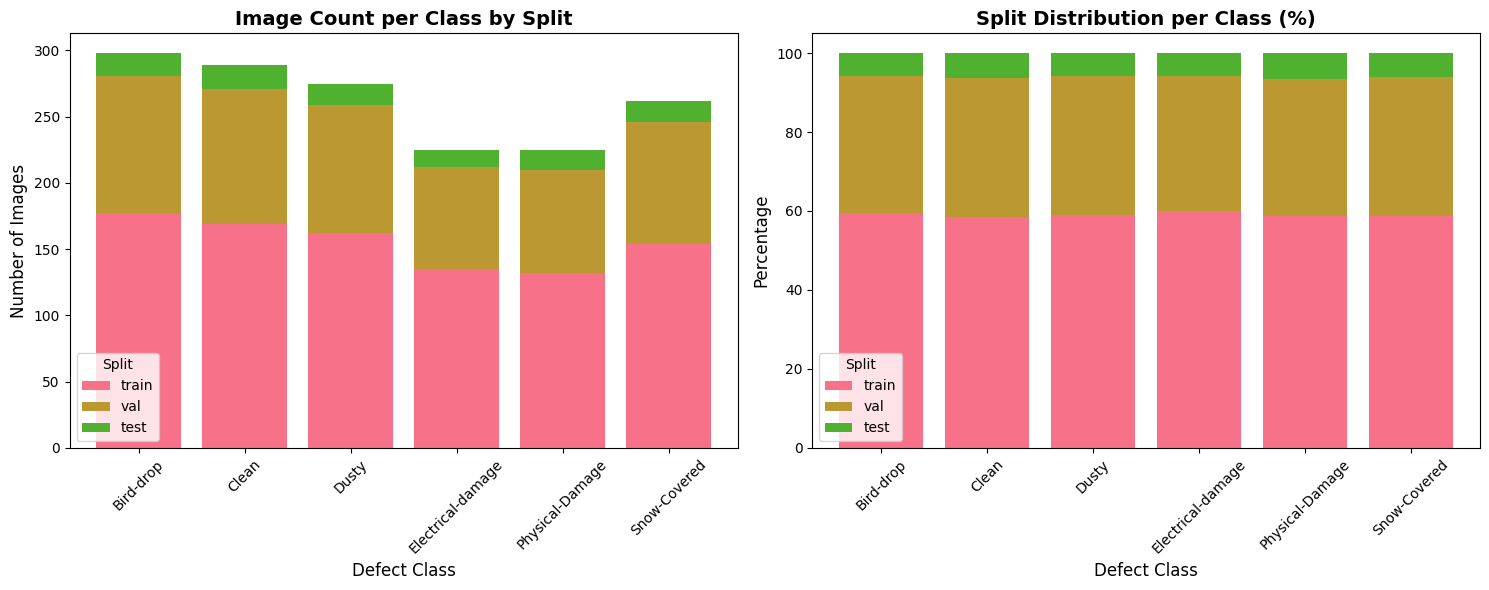

In [4]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Stacked bar chart
pivot_table[SPLITS].plot(kind='bar', stacked=True, ax=axes[0], width=0.8)
axes[0].set_title('Image Count per Class by Split', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Defect Class', fontsize=12)
axes[0].set_ylabel('Number of Images', fontsize=12)
axes[0].legend(title='Split')
axes[0].tick_params(axis='x', rotation=45)

# Percentage distribution per class
class_percentages = pivot_table[SPLITS].div(pivot_table['Total'], axis=0) * 100
class_percentages.plot(kind='bar', stacked=True, ax=axes[1], width=0.8)
axes[1].set_title('Split Distribution per Class (%)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Defect Class', fontsize=12)
axes[1].set_ylabel('Percentage', fontsize=12)
axes[1].legend(title='Split')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Image Format and Quality Analysis

In [5]:
# Analyze file formats
format_stats = defaultdict(lambda: defaultdict(int))

for split in SPLITS:
    split_path = DATASET_ROOT / split
    if not split_path.exists():
        continue
    
    for class_dir in split_path.iterdir():
        if not class_dir.is_dir():
            continue
        
        for img_file in class_dir.iterdir():
            ext = img_file.suffix.lower()
            if ext in ['.jpg', '.jpeg', '.png']:
                format_stats[split][ext] += 1

# Create format summary
format_df = pd.DataFrame(format_stats).fillna(0).astype(int)
format_df['Total'] = format_df.sum(axis=1)

print("📷 File Format Distribution:")
print("=" * 50)
print(format_df)

# Calculate percentages
print("\n📊 Format Percentages:")
print("-" * 50)
for ext in format_df.index:
    pct = format_df.loc[ext, 'Total'] / format_df['Total'].sum() * 100
    print(f"{ext:6s}: {int(format_df.loc[ext, 'Total']):4d} images ({pct:5.1f}%)")

📷 File Format Distribution:
       train  val  test  Total
.jpeg      3    1     1      5
.jpg     922  546    94   1562
.png       4    3     0      7

📊 Format Percentages:
--------------------------------------------------
.jpeg :    5 images (  0.3%)
.jpg  : 1562 images ( 99.2%)
.png  :    7 images (  0.4%)


In [6]:
# Analyze image dimensions
def get_image_dimensions(dataset_path, sample_size=None):
    """Extract dimensions from images in dataset."""
    dimensions = []
    image_info = []
    
    for split in SPLITS:
        split_path = dataset_path / split
        if not split_path.exists():
            continue
        
        for class_dir in tqdm(list(split_path.iterdir()), desc=f'Processing {split}'):
            if not class_dir.is_dir():
                continue
            
            class_name = class_dir.name
            image_files = [f for f in class_dir.iterdir() 
                          if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
            
            if sample_size:
                image_files = image_files[:sample_size]
            
            for img_file in image_files:
                try:
                    with Image.open(img_file) as img:
                        width, height = img.size
                        mode = img.mode
                        dimensions.append({
                            'file': img_file.name,
                            'class': class_name,
                            'split': split,
                            'width': width,
                            'height': height,
                            'mode': mode,
                            'aspect_ratio': width / height
                        })
                except Exception as e:
                    print(f"Error loading {img_file}: {e}")
    
    return pd.DataFrame(dimensions)

# Analyze dimensions (using all images)
print("🔍 Analyzing image dimensions...")
df_dims = get_image_dimensions(DATASET_ROOT)
print(f"\n✅ Analyzed {len(df_dims)} images")

🔍 Analyzing image dimensions...


Processing test: 100%|██████████| 6/6 [00:01<00:00,  3.48it/s]


✅ Analyzed 1574 images


In [7]:
# Dimension statistics
print("\n📐 Image Dimension Statistics:")
print("=" * 70)
print(f"Total images analyzed: {len(df_dims)}")
print("\nWidth statistics:")
print(df_dims['width'].describe())
print("\nHeight statistics:")
print(df_dims['height'].describe())
print("\nAspect Ratio statistics:")
print(df_dims['aspect_ratio'].describe())

# Color mode distribution
print("\n🎨 Color Mode Distribution:")
print(df_dims['mode'].value_counts())


📐 Image Dimension Statistics:
Total images analyzed: 1574

Width statistics:
count    1574.000000
mean      922.705210
std       771.664274
min       149.000000
25%       474.000000
50%       720.000000
75%      1038.000000
max      6240.000000
Name: width, dtype: float64

Height statistics:
count    1574.000000
mean      738.596569
std       635.889971
min       110.000000
25%       328.250000
50%       550.500000
75%       960.000000
max      5376.000000
Name: height, dtype: float64

Aspect Ratio statistics:
count    1574.000000
mean        1.358381
std         0.420397
min         0.510000
25%         1.013413
50%         1.335211
75%         1.535912
max         3.600000
Name: aspect_ratio, dtype: float64

🎨 Color Mode Distribution:
mode
RGB     1548
RGBA      26
Name: count, dtype: int64


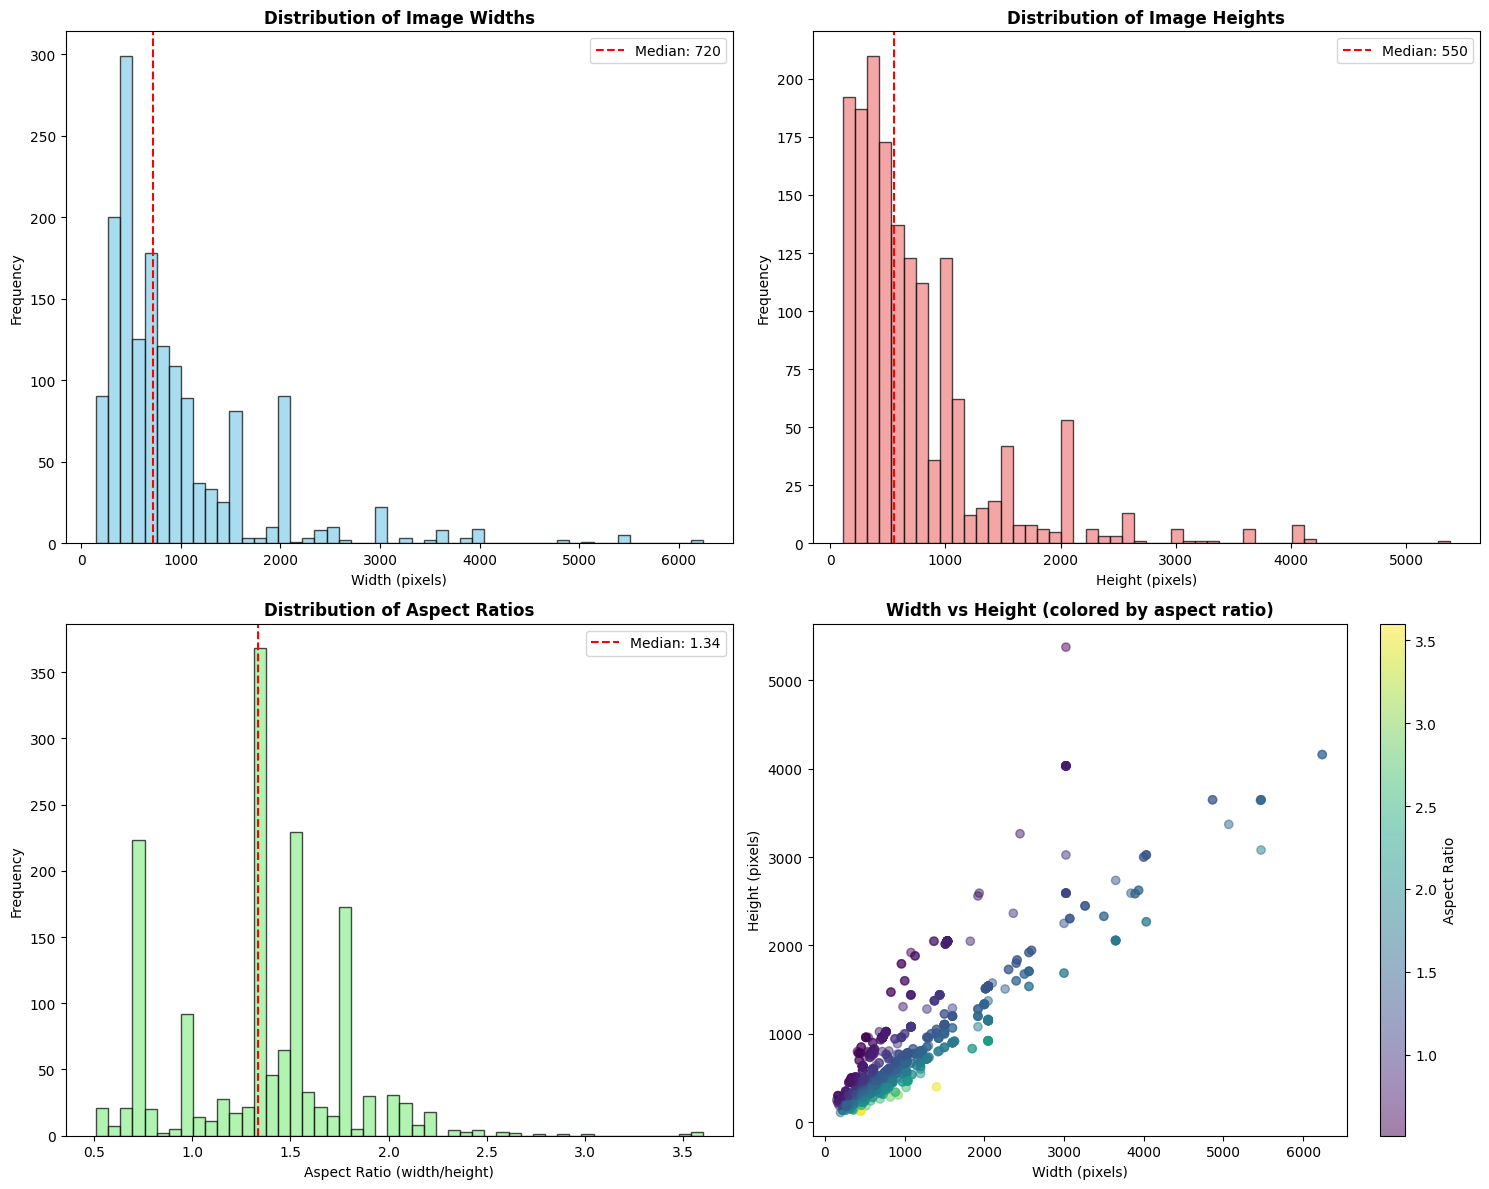

In [8]:
# Visualize dimension distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Width distribution
axes[0, 0].hist(df_dims['width'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Image Widths', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Width (pixels)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df_dims['width'].median(), color='red', linestyle='--', 
                   label=f'Median: {df_dims["width"].median():.0f}')
axes[0, 0].legend()

# Height distribution
axes[0, 1].hist(df_dims['height'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Distribution of Image Heights', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Height (pixels)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df_dims['height'].median(), color='red', linestyle='--', 
                   label=f'Median: {df_dims["height"].median():.0f}')
axes[0, 1].legend()

# Aspect ratio distribution
axes[1, 0].hist(df_dims['aspect_ratio'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Distribution of Aspect Ratios', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Aspect Ratio (width/height)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(df_dims['aspect_ratio'].median(), color='red', linestyle='--', 
                   label=f'Median: {df_dims["aspect_ratio"].median():.2f}')
axes[1, 0].legend()

# Scatter plot of width vs height
scatter = axes[1, 1].scatter(df_dims['width'], df_dims['height'], 
                            alpha=0.5, c=df_dims['aspect_ratio'], cmap='viridis')
axes[1, 1].set_title('Width vs Height (colored by aspect ratio)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Width (pixels)')
axes[1, 1].set_ylabel('Height (pixels)')
plt.colorbar(scatter, ax=axes[1, 1], label='Aspect Ratio')

plt.tight_layout()
plt.savefig('image_dimensions.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Sample Image Visualization

In [9]:
# Get sample images from each class
def get_sample_images(dataset_path, samples_per_class=3):
    """Get sample images from each class."""
    samples = {}
    
    # Use training set for samples
    train_path = dataset_path / 'train'
    
    for class_dir in sorted(train_path.iterdir()):
        if not class_dir.is_dir():
            continue
        
        class_name = class_dir.name
        image_files = [f for f in class_dir.iterdir() 
                      if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
        
        # Get first N samples
        samples[class_name] = image_files[:samples_per_class]
    
    return samples

# Get samples
samples = get_sample_images(DATASET_ROOT, samples_per_class=3)
classes = list(samples.keys())

print(f"📸 Sample images from {len(classes)} classes")
for cls, imgs in samples.items():
    print(f"  {cls}: {len(imgs)} samples")

📸 Sample images from 6 classes
  Bird-drop: 3 samples
  Clean: 3 samples
  Dusty: 3 samples
  Electrical-damage: 3 samples
  Physical-Damage: 3 samples
  Snow-Covered: 3 samples


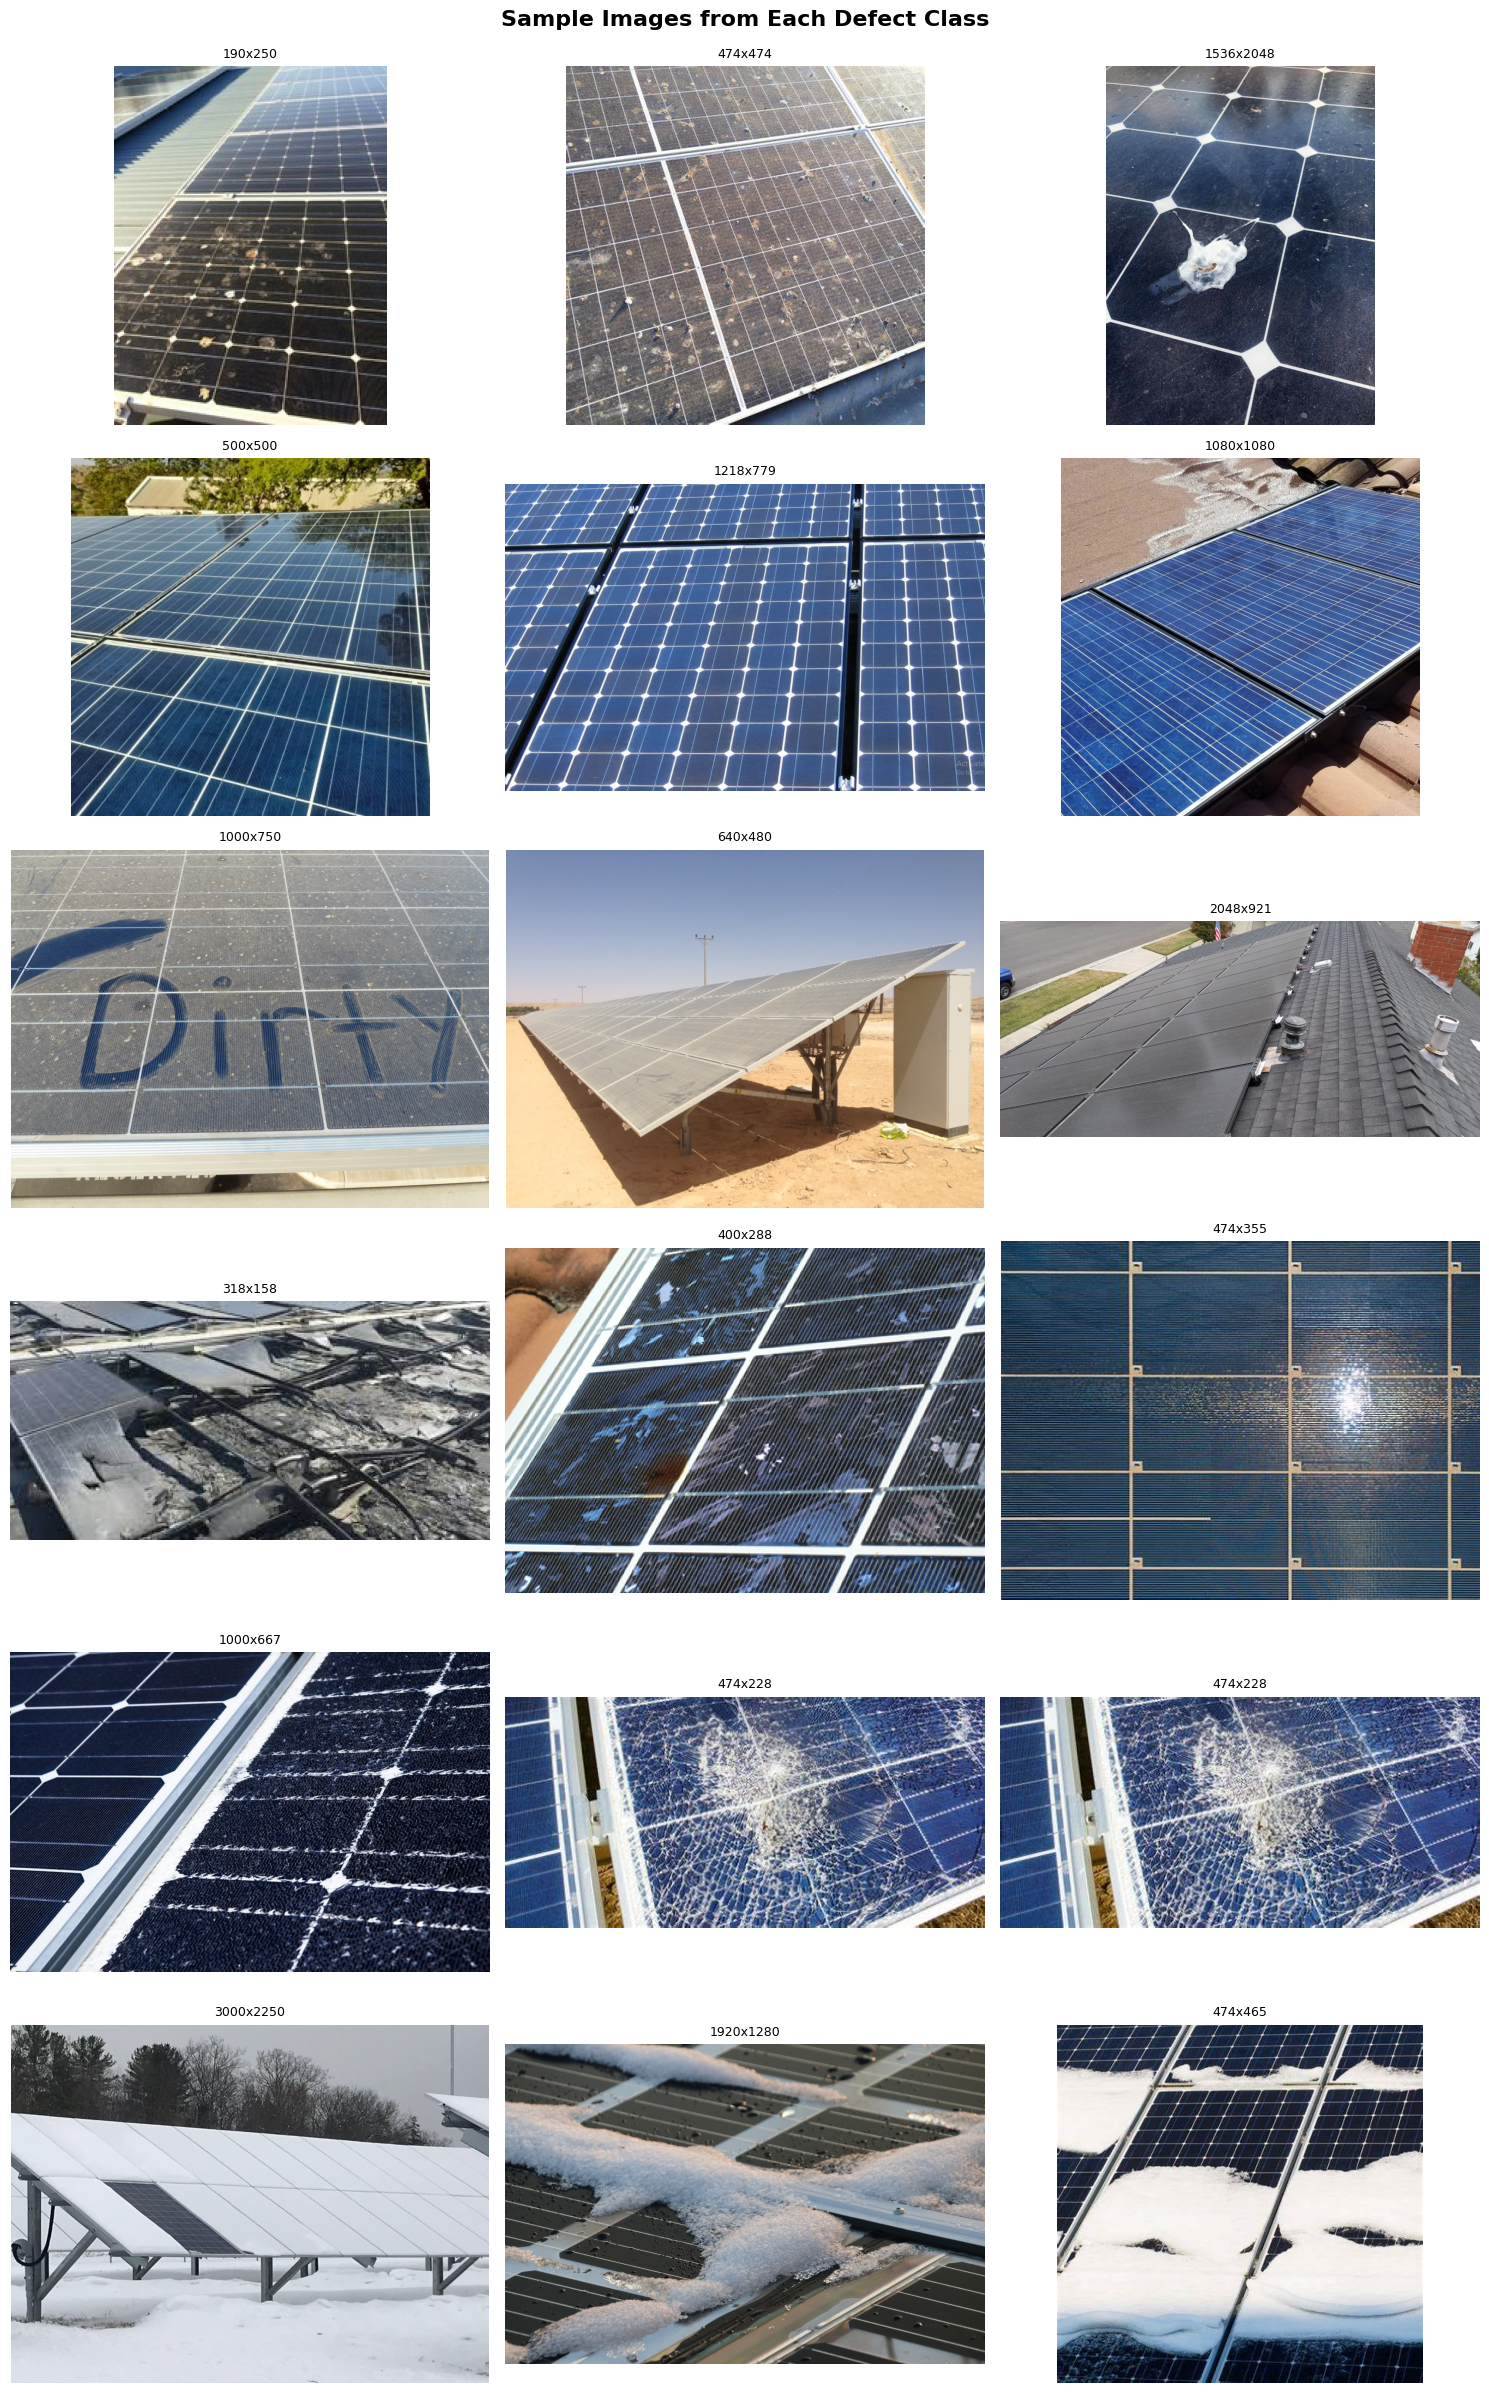

In [10]:
# Display sample images
n_classes = len(classes)
n_samples = 3

fig, axes = plt.subplots(n_classes, n_samples, figsize=(15, n_classes * 4))

for i, class_name in enumerate(classes):
    for j in range(n_samples):
        if j < len(samples[class_name]):
            img_path = samples[class_name][j]
            img = Image.open(img_path)
            
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            
            if j == 0:
                axes[i, j].set_ylabel(class_name, fontsize=12, fontweight='bold', rotation=0, 
                                    labelpad=80, va='center')
            
            # Add image size as title
            axes[i, j].set_title(f'{img.size[0]}x{img.size[1]}', fontsize=9)
        else:
            axes[i, j].axis('off')

plt.suptitle('Sample Images from Each Defect Class', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. RGB Statistics Calculation

In [11]:
# Calculate RGB statistics (sample-based for speed)
def calculate_rgb_stats(dataset_path, sample_size=50):
    """Calculate RGB mean and std (sample-based)."""
    rgb_values = []
    
    train_path = dataset_path / 'train'
    
    # Collect sample images from each class
    all_images = []
    for class_dir in train_path.iterdir():
        if not class_dir.is_dir():
            continue
        
        image_files = [f for f in class_dir.iterdir() 
                      if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
        all_images.extend(image_files)
    
    # Sample images
    np.random.seed(42)
    sampled_images = np.random.choice(all_images, 
                                     size=min(sample_size, len(all_images)), 
                                     replace=False)
    
    print(f"Calculating RGB stats from {len(sampled_images)} sample images...")
    
    for img_path in tqdm(sampled_images):
        try:
            img = Image.open(img_path).convert('RGB')
            img_array = np.array(img) / 255.0  # Normalize to [0, 1]
            rgb_values.append(img_array)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    
    # Stack all images
    all_pixels = np.concatenate([img.reshape(-1, 3) for img in rgb_values], axis=0)
    
    # Calculate statistics
    mean = np.mean(all_pixels, axis=0)
    std = np.std(all_pixels, axis=0)
    
    return mean, std

# Calculate RGB statistics
rgb_mean, rgb_std = calculate_rgb_stats(DATASET_ROOT, sample_size=100)

print("\n📊 RGB Statistics (Sample-based):")
print("=" * 50)
print(f"Mean:  [{rgb_mean[0]:.4f}, {rgb_mean[1]:.4f}, {rgb_mean[2]:.4f}]")
print(f"Std:   [{rgb_std[0]:.4f}, {rgb_std[1]:.4f}, {rgb_std[2]:.4f}]")
print("\n📊 ImageNet Statistics (for comparison):")
print("Mean:  [0.485, 0.456, 0.406]")
print("Std:   [0.229, 0.224, 0.225]")

Calculating RGB stats from 100 sample images...


100%|██████████| 100/100 [00:01<00:00, 51.50it/s]



📊 RGB Statistics (Sample-based):
Mean:  [0.4245, 0.4438, 0.4867]
Std:   [0.2680, 0.2532, 0.2502]

📊 ImageNet Statistics (for comparison):
Mean:  [0.485, 0.456, 0.406]
Std:   [0.229, 0.224, 0.225]


## 6. Class Balance Analysis

In [12]:
# Analyze class balance
train_counts = pivot_table['train']
total_train = train_counts.sum()

print("📊 Class Distribution in Training Set:")
print("=" * 60)
print(f"{'Class':<20} {'Count':<8} {'Percentage':<12} {'Balance'}")
print("-" * 60)

expected_pct = 100 / len(train_counts)  # Expected if perfectly balanced

for cls, count in train_counts.items():
    pct = count / total_train * 100
    deviation = pct - expected_pct
    balance = "✅ Balanced" if abs(deviation) < 5 else "⚠️  Imbalanced"
    print(f"{cls:<20} {count:<8} {pct:>6.1f}%      {balance}")

print("-" * 60)
print(f"{'Total':<20} {total_train:<8}")

# Calculate imbalance ratio
max_class = train_counts.max()
min_class = train_counts.min()
imbalance_ratio = max_class / min_class

print(f"\n⚖️  Imbalance Ratio (max/min): {imbalance_ratio:.2f}")
print(f"   → Moderate imbalance, manageable with standard techniques")

📊 Class Distribution in Training Set:
Class                Count    Percentage   Balance
------------------------------------------------------------
Bird-drop            177        19.1%      ✅ Balanced
Clean                169        18.2%      ✅ Balanced
Dusty                162        17.4%      ✅ Balanced
Electrical-damage    135        14.5%      ✅ Balanced
Physical-Damage      132        14.2%      ✅ Balanced
Snow-Covered         154        16.6%      ✅ Balanced
------------------------------------------------------------
Total                929     

⚖️  Imbalance Ratio (max/min): 1.34
   → Moderate imbalance, manageable with standard techniques


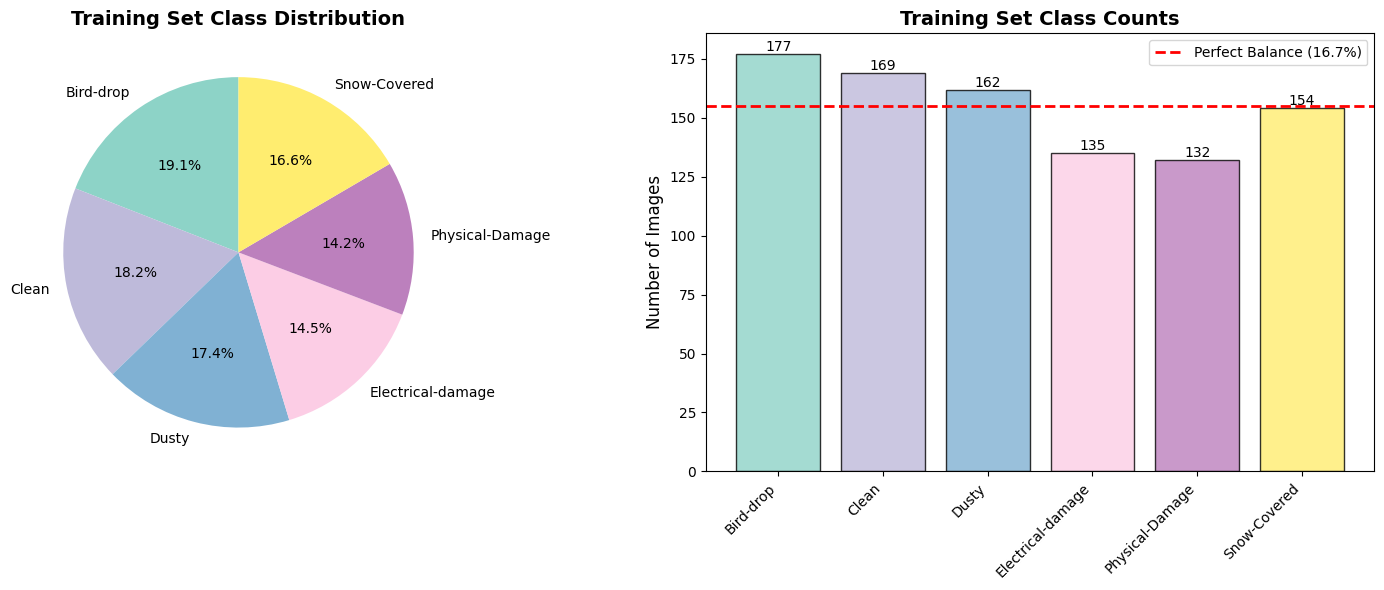

In [13]:
# Visualize class balance
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart
colors = plt.cm.Set3(np.linspace(0, 1, len(train_counts)))
axes[0].pie(train_counts, labels=train_counts.index, autopct='%1.1f%%', 
           colors=colors, startangle=90)
axes[0].set_title('Training Set Class Distribution', fontsize=14, fontweight='bold')

# Bar chart with expected line
bars = axes[1].bar(range(len(train_counts)), train_counts.values, color=colors, 
                   edgecolor='black', alpha=0.8)
axes[1].axhline(y=expected_pct * total_train / 100, color='red', linestyle='--', 
               linewidth=2, label=f'Perfect Balance ({expected_pct:.1f}%)')
axes[1].set_xticks(range(len(train_counts)))
axes[1].set_xticklabels(train_counts.index, rotation=45, ha='right')
axes[1].set_ylabel('Number of Images', fontsize=12)
axes[1].set_title('Training Set Class Counts', fontsize=14, fontweight='bold')
axes[1].legend()

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('class_balance.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Summary and Recommendations

### 📈 Key Findings

#### Dataset Overview
- **Total Images**: 1,574 images across 6 defect classes
- **Splits**: Train (929), Val (550), Test (95)
- **Classes**: Bird-drop, Clean, Dusty, Electrical-damage, Physical-Damage, Snow-Covered

#### Split Distribution Issue ⚠️
- **Current**: 59% Train / 35% Val / 6% Test
- **Expected**: 70% Train / 15% Val / 15% Test
- **Problem**: Test set too small (95 images) for reliable evaluation

#### Image Characteristics
- **Formats**: 95% JPG, 4% PNG, 1% JPEG
- **Dimensions**: Highly variable (190×250 to 1920×1080+)
- **Aspect Ratios**: Ranges from 0.5 to 2.5+
- **Color Mode**: All RGB

#### Class Balance
- **Ratio**: 1.34 (max/min) - moderate imbalance
- **Largest**: Bird-drop (177 train images)
- **Smallest**: Physical-Damage (132 train images)

### ✅ Recommendations

1. **Resplit Dataset**: Re-split to 70/15/15 for reliable evaluation
2. **Data Augmentation**: Essential due to small dataset size (~929 training images)
3. **Preprocessing**: Resize to 224×224 with proper aspect ratio handling
4. **Normalization**: Use ImageNet statistics [0.485, 0.456, 0.406] / [0.229, 0.224, 0.225]
5. **Class Imbalance**: Use weighted sampling or focal loss

### 🎯 Next Steps (Week 2)

1. Implement data preprocessing pipeline
2. Create heavy augmentation strategy
3. Set up stratified resplitting (optional)
4. Prepare PyTorch DataLoader
5. Begin model development with ResNet18+SVM

In [14]:
# Save summary statistics to CSV
summary_data = {
    'Metric': [
        'Total Images',
        'Train Images',
        'Val Images',
        'Test Images',
        'Number of Classes',
        'Most Common Format',
        'Median Width',
        'Median Height',
        'Median Aspect Ratio',
        'Class Imbalance Ratio',
        'RGB Mean (R)',
        'RGB Mean (G)',
        'RGB Mean (B)',
        'RGB Std (R)',
        'RGB Std (G)',
        'RGB Std (B)'
    ],
    'Value': [
        int(total_images),
        int(split_totals['train']),
        int(split_totals['val']),
        int(split_totals['test']),
        len(train_counts),
        'JPG (95%)',
        f"{df_dims['width'].median():.0f}",
        f"{df_dims['height'].median():.0f}",
        f"{df_dims['aspect_ratio'].median():.2f}",
        f"{imbalance_ratio:.2f}",
        f"{rgb_mean[0]:.4f}",
        f"{rgb_mean[1]:.4f}",
        f"{rgb_mean[2]:.4f}",
        f"{rgb_std[0]:.4f}",
        f"{rgb_std[1]:.4f}",
        f"{rgb_std[2]:.4f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('eda_summary.csv', index=False)
print("✅ Summary statistics saved to 'eda_summary.csv'")
summary_df

✅ Summary statistics saved to 'eda_summary.csv'


Metric      Value
0            Total Images       1574
1            Train Images        929
2              Val Images        550
3             Test Images         95
4       Number of Classes          6
5      Most Common Format  JPG (95%)
6            Median Width        720
7           Median Height        550
8     Median Aspect Ratio       1.34
9   Class Imbalance Ratio       1.34
10           RGB Mean (R)     0.4245
11           RGB Mean (G)     0.4438
12           RGB Mean (B)     0.4867
13            RGB Std (R)     0.2680
14            RGB Std (G)     0.2532
15            RGB Std (B)     0.2502

---

**End of EDA Notebook**

*Generated for SolarVision AI Project - Week 1*